In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import random
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import gc
import lightgbm as lgb
import joblib
from lightgbm import LGBMRegressor

# Business Understanding

Sales forecasting is an important element of a business's planning, particularly crucial for a retail business. Sales forecasting is the process of estimating revenue or the quantity of products sold based on past data. Sales forecasts can be made for a specific time period (month, quarter, year). Accurate sales forecasting can help a business manage purchase orders, inventory, and ultimately improve revenue. Recognizing its significance, Walmart collaborated with the Makridakis Open Forecasting Center (MOFC) to organize the M5 Forecasting competition on Kaggle. Through this competition, Walmart hopes to find an optimized sales forecasting solution.

Walmart is one of the largest retail chains in the world, with over 11,000 stores worldwide. The Makridakis Open Forecasting Center is a leading organization in the field of forecasting, founded by Makridakis, one of the pioneers in this field. There have been four forecasting competitions organized by Professor Makridakis in the past for the purpose of sharing and advancing research. The M5 Forecasting competition is the fifth edition organized by MOFC in collaboration with Walmart.

With a dataset spanning five years of sales statistics from Walmart (2011-2016) for all the stores in three states in the United States, the task of the competition is to use the provided data to forecast the sales for each of the 3,049 different products across 10 different stores for the next 28 days.

Accurate sales forecasting can help Walmart in the following ways:

- Managing purchase orders and shipments effectively.
- Improving inventory management.
- Facilitating advertising decision-making.
- Optimizing sales strategies.

# EDA

## 1. Overview

The dataset provided by Walmart is a hierarchical timeseries dataset. The hierarchical structure of the dataset can be represented as follows:

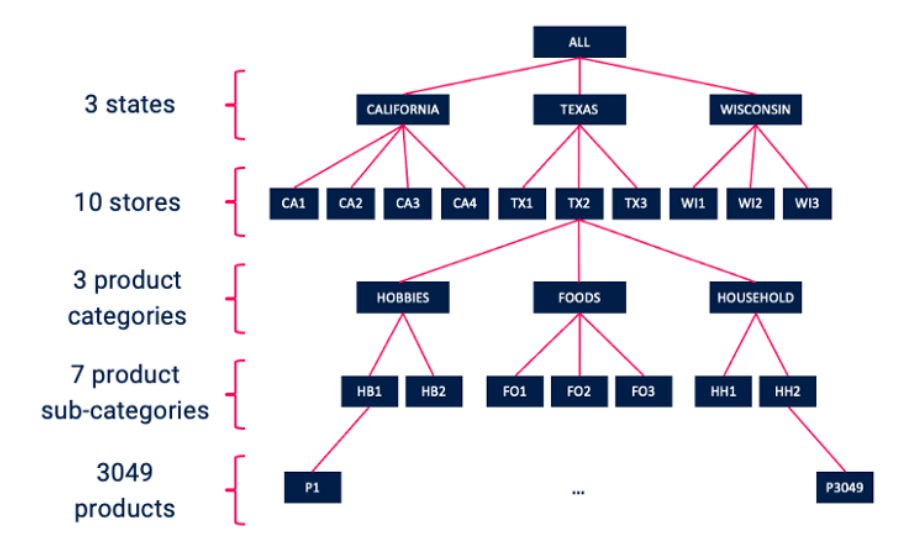

In [2]:
load_img("/kaggle/input/walmart/walmart.png")

In [3]:
%%time
base_path = "/kaggle/input/m5-forecasting-accuracy/"
calendar = pd.read_csv(f"{base_path}calendar.csv")
train_eva = pd.read_csv(f"{base_path}sales_train_evaluation.csv")
train_val = pd.read_csv(f"{base_path}sales_train_validation.csv")
sell_prices = pd.read_csv(f"{base_path}sell_prices.csv")
sample_sub = pd.read_csv(f"{base_path}sample_submission.csv")

CPU times: user 11.5 s, sys: 1.39 s, total: 12.8 s
Wall time: 16.6 s


The dataset consists of 5 file .csv: **sales_train_evaluation.csv**, **sales_train_validation.csv**, **calendar.csv**, **sell_prices.csv**, **sample_submission.csv**.

The dataset includes two files: **sales_train_evaluation.csv** and **sales_train_validation.csv**. These files are the main data used for model building. Each file contains 6 columns providing information about the product, its category, the store code, and the remaining columns represent the sequential dates and the corresponding sales quantity for each day.

The validation file has **1919** columns, which means it stores information about the quantity of products sold for **1913** days. The evaluation file has **1947** columns, similar to the validation file but with an additional 28 days, resulting in a total of **1941** days. You can use one file for training and the other file for evaluation.

Both files have **30,490 rows**, representing 3,049 different products sold across 10 stores.

In [4]:
train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [5]:
train_eva

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


The **sell_prices.csv** file stores information about the prices of products combined with the store codes for a particular week of the year. The week is represented by a specific code in the format "year + week" and can be cross-referenced with the information in the calendar.csv file. The selling prices may vary across different stores within different states or at different time periods.

This file provides the price data that corresponds to the products and stores in the other datasets, allowing for analysis of price fluctuations and their impact on sales. By linking the product, store, and time information, it enables a comprehensive understanding of the pricing dynamics in relation to the sales performance.

In [6]:
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00



The **calendar.csv** file contains information about specific dates, including the day, month, year, and the corresponding "year + week" code. Additionally, it includes information about any special events that occur on a particular day, such as Valentine's Day, Super Bowl, etc.

Moreover, there are three columns that provide information about whether the specific day is a SNAP day or not. SNAP (Supplemental Nutrition Assistance Program) is a government assistance program in the United States that provides eligible individuals with funds to purchase food. The presence of SNAP information in the dataset indicates whether the particular day is eligible for SNAP benefits.

By incorporating the date, week, special events, and SNAP day information, the calendar dataset offers context and additional features that can be used for analyzing and forecasting sales. These factors may influence consumer behavior and impact sales patterns.

In [7]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [8]:
sample_sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. train_validation.csv

### 2.1 Total sales

In [9]:
# Get days columns name
days_col = [f"d_{i}" for i in range(1, 1914)]

merged = pd.merge(train_val[days_col].sum().reset_index(), 
                  calendar[['date', 'd']], 
                  left_on='index', 
                  right_on='d')
merged['date'] = pd.to_datetime(merged['date'])

fig = px.line(merged, x='date', y=0)
fig.update_layout(title='Total Sales Over Time', yaxis_title='Total Sales', height=600, width=950)
fig.update_layout(xaxis=dict(
        tickformat='%d-%m-%Y',
        title_text="Date"))
fig.show()

**Insights:**
- The total sales have shown a growth trend over time, indicating that Walmart has been experiencing relatively sustainable growth during the given period.
- There are a few days with zero sales, specifically on December 25th each year, which is Christmas Day. This is the only day in the year when Walmart stores are closed, hence no sales are recorded on that day.

In [10]:
monthly_sales = merged.groupby(pd.Grouper(key='date', freq='M')).sum(numeric_only=True).reset_index()
fig = px.line(monthly_sales, x='date', y=0)
fig.update_layout(title={'text': 'Total Sales by Month', 'x':0.5, 'xanchor':'center'}, 
                  xaxis_title='Month', 
                  yaxis_title='Total Sales', 
                  height=600, width=950)
fig.update_layout(xaxis=dict(tickformat='%Y', title_text="Date"))
#fig.update_layout(xaxis=dict(tick0="2011-01-01", dtick="M1"))
fig.show()

**Insights:**
- The total sales for the three states range from 1 million to 1.2 million products per month.
- The sales in January 2011 are relatively low compared to other months. This is due to the data collection starting on January 29, 2011, resulting in only three days' worth of data being included in the monthly sales aggregation.
- There is a significant drop in sales in the last month. This is because the last month's data from the train_validation file does not contain a complete set of days like the other months.
- The monthly sales chart provides a clear visualization of Walmart's sales growth over the years.

## 2.2 Total sales by state

In [11]:
total_sale_state = train_val.groupby("state_id").sum(numeric_only=True)

fig = go.Figure()

for i in ["CA", "TX", "WI"]:
    state = pd.merge(total_sale_state.loc[i].reset_index(),
             calendar[['date', 'd']],
             left_on='index',
             right_on='d')
    state['date'] = pd.to_datetime(state['date'])

    state_monthly = state.groupby(pd.Grouper(key='date', freq='M')).sum(numeric_only=True)
    fig.add_trace(go.Scatter(x=state_monthly.index, y=state_monthly[i], name=i))

fig.update_layout(title={'text': 'Monthly Sales by State', 'x':0.5, 'xanchor':'center'},
                  xaxis_title='Month', 
                  yaxis_title='Total Sales', 
                  legend=dict(x=0, y=-0.2),
                  xaxis=dict(tickformat='%Y', title_text="Date"))
fig.update_layout(height=600, width=900)
fig.update_layout(legend=dict(x=1, y=1))
fig.show()

In [12]:
fig = go.Figure(data=[go.Pie(labels=total_sale_state.sum(axis=1).reset_index()['state_id'], 
                             values=total_sale_state.sum(axis=1).reset_index()[0], 
                             textinfo='label+value+percent')])
fig.update_layout(title='Total Sales Distribution by State')
fig.show()

**Insights:**
- The state of California has the highest sales among the three states, accounting for 43.6% of the total sales.
- Texas and Wisconsin have relatively similar sales, with Texas accounting for 28.8% and Wisconsin accounting for 27.6% of the total sales.
- The sales patterns among the states exhibit some similarities, indicating potential market trends or consumer behavior trends that are consistent across the states.

### 2.3 Total sales by store

In [13]:
# Create subplots with shared y-axis
total_sale_store = train_val.groupby("store_id").sum(numeric_only=True)
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, horizontal_spacing=0.02)

for i in total_sale_store.index:
    store = pd.merge(total_sale_store.loc[i].reset_index(),
             calendar[['date', 'd']],
             left_on='index',
             right_on='d')
    store['date'] = pd.to_datetime(store['date'])
    store_monthly = store.groupby(pd.Grouper(key='date', freq='M')).sum(numeric_only=True)
    
    if store_monthly.columns[0][:2] == "CA":
        fig.add_trace(go.Scatter(x=store_monthly.index, y=store_monthly[i], name=i), row=1, col=1)
    elif store_monthly.columns[0][:2] == "TX":
        fig.add_trace(go.Scatter(x=store_monthly.index, y=store_monthly[i], name=i), row=1, col=2)
    else:
        fig.add_trace(go.Scatter(x=store_monthly.index, y=store_monthly[i], name=i), row=1, col=3)

# Update the layout of each subplot's x-axis
for i in range(1, 4):
    fig.update_xaxes(title_text=None, tickformat='%Y', row=1, col=i)

# Update the titles of the subplots
fig.update_layout(title={'text': 'Total sale per store by month', 'x':0.5, 'xanchor':'center'})
fig.add_annotation(text="CA", xref='paper', yref='paper', x=0.15, y=1.1, font=dict(size=16), showarrow=False)
fig.add_annotation(text="TX", xref='paper', yref='paper', x=0.5, y=1.1, font=dict(size=16), showarrow=False)
fig.add_annotation(text="WI", xref='paper', yref='paper', x=0.85, y=1.1, font=dict(size=16), showarrow=False)
fig.update_xaxes(title_text='Date', row=1, col=2)
fig.update_yaxes(title_text='Sales', row=1, col=1)
fig.update_layout(legend=dict(orientation='h', y=-0.2))
fig.update_layout(height=500, width=930)

# Show the figure
fig.show()

**Insights:**
- Store CA_3 has the highest sales among all the stores, with sales ranging from 150,000 to 200,000 products per month.
- The remaining stores have sales ranging from 50,000 to 150,000 products per month.
- This partially explains why California has higher sales compared to the other states. California has 4 stores, while the other states have only 3 stores each.

### 2.4 Total sales by Category

In [14]:
total_sale_cat = train_val.groupby('cat_id').sum(numeric_only=True)

fig = go.Figure()
# Giữ thứ tự FOODS, HOUSEHOLD, HOBBIES plot đúng thứ tự màu
for i in ['FOODS', 'HOUSEHOLD','HOBBIES']:
    cat = pd.merge(total_sale_cat.loc[i].reset_index(),
             calendar[['date', 'd']],
             left_on='index',
             right_on='d')
    cat['date'] = pd.to_datetime(cat['date'])

    cat_monthly = cat.groupby(pd.Grouper(key='date', freq='M')).sum(numeric_only=True)
    fig.add_trace(go.Scatter(x=cat_monthly.index, y=cat_monthly[i], name=i))

fig.update_layout(title={'text': 'Monthly Sales by Category', 'x':0.5, 'xanchor':'center'},
                  xaxis_title='Date', 
                  yaxis_title='Total Sales', 
                  legend=dict(x=0, y=-0.2),
                  xaxis=dict(tickformat='%Y'))
fig.update_layout(height=600, width=900)
fig.update_layout(legend=dict(x=1, y=1))
fig.show()

In [15]:
cat_sales_dis = train_val.groupby('cat_id').sum(numeric_only=True).sum(axis=1).reset_index()
fig = go.Figure(data=[go.Pie(labels=cat_sales_dis['cat_id'], 
                             values=cat_sales_dis[0], 
                             textinfo='label+value+percent')])
fig.update_layout(title='Sales Distribution by Category')
fig.show()

In [16]:
cat_items_dict = dict()
for i in ["FOODS", "HOBBIES", "HOUSEHOLD"]:
    cat_items_dict[i] = train_val[train_val['cat_id'] == i]['item_id'].nunique()
cat_items = pd.DataFrame.from_dict(cat_items_dict, orient='index', columns=['num_item']).reset_index()

fig = go.Figure(data=[go.Pie(labels=cat_items['index'], 
                             values=cat_items['num_item'], 
                             textinfo='label+value+percent')])
fig.update_layout(title='Number of Item by Category')
fig.show()

**Insights:**
- The sales of FOODS category outperform the HOBBIES and HOUSEHOLD categories.
- FOODS account for 68.6% of the total sales, HOUSEHOLD accounts for 22%, and HOBBIES accounts for 9.32%.
- FOODS have the most diverse range of products, representing 47.1% of the total products sold, which is nearly half of the total.

### 2.5 Total sales by Department

In [17]:
fig = make_subplots(rows=3, cols=7, shared_yaxes=True, shared_xaxes=True, horizontal_spacing=0.02, vertical_spacing=0.02)

for i in ["CA", "TX", "WI"]:
    for j,k in enumerate(sorted(list(train_val["dept_id"].unique()))):
        dept = pd.merge(train_val[train_val["state_id"] == i].groupby("dept_id").sum(numeric_only=True).loc[k].reset_index(),
                 calendar[['date', 'd']],
                 left_on='index',
                 right_on='d')
        dept['date'] = pd.to_datetime(dept['date'])
        dept_monthly = dept.groupby(pd.Grouper(key='date', freq='M')).sum(numeric_only=True)
    
        if i == "CA":
            fig.add_trace(go.Scatter(x=dept_monthly.index, y=dept_monthly[k], name=k), row=1, col=j+1)
            fig.update_yaxes(title_text="CA", row=1, col=7)
        elif i == "TX":
            fig.add_trace(go.Scatter(x=dept_monthly.index, y=dept_monthly[k], name=k), row=2, col=j+1)
            fig.update_yaxes(title_text="TX", row=2, col=7)
        else:
            fig.add_trace(go.Scatter(x=dept_monthly.index, y=dept_monthly[k], name=k), row=3, col=j+1)
            fig.update_yaxes(title_text="WI", row=3, col=7)

# Update the titles
fig.update_layout(title='Total sale by departmnet')
fig.update_xaxes(title_text='Date', row=3, col=4)
fig.update_layout(showlegend=False)
fig.update_layout(height=600, width=930)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i,j in enumerate(sorted(list(train_val["dept_id"].unique()))):
    fig.update_traces(selector=dict(name=j), line=dict(color=colors[i]))
    
fig.add_annotation(text="FOODS_1", xref='paper', yref='paper', x=0.03, y=1.05, font=dict(size=12), showarrow=False)
fig.add_annotation(text="FOODS_2", xref='paper', yref='paper', x=0.17, y=1.05, font=dict(size=12), showarrow=False)
fig.add_annotation(text="FOODS_3", xref='paper', yref='paper', x=0.31, y=1.05, font=dict(size=12), showarrow=False)
fig.add_annotation(text="HOBBIES_1", xref='paper', yref='paper', x=0.5, y=1.05, font=dict(size=12), showarrow=False)
fig.add_annotation(text="HOBBIES_2", xref='paper', yref='paper', x=0.64, y=1.05, font=dict(size=12), showarrow=False)
fig.add_annotation(text="HOUSEHOLD_1", xref='paper', yref='paper', x=0.855, y=1.05, font=dict(size=12), showarrow=False)
fig.add_annotation(text="HOUSEHOLD_2", xref='paper', yref='paper', x=1, y=1.05, font=dict(size=12), showarrow=False)
fig.show()

**Insights:**
- Among the FOODS categories, FOODS_3 has the highest sales, similarly to HOBBIES_1 and HOUSEHOLD_1 in their respective categories.
- FOODS_3 is the top-selling product category, with an average sales of around 150,000 in TX and WI, and around 200,000 in CA.
- HOUSEHOLD_1 is the second-highest selling category.
- HOBBIES_2 is the category with the lowest sales, with an average of only around 2,000 products sold in each state.
- FOODS_2 shows a strong upward trend in sales in the later months in WI.

### 2.6 Total sales by specific item
Some random product

In [18]:
random_products = random.sample(list(train_val.index.unique()), 3)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
# Tạo subplot grid
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05, 
                    subplot_titles=[
                        f"Product {train_val.loc[product]['id'][:-11]}"
                        for product in random_products
                    ])
for i, product in enumerate(random_products):
    color = colors[i]
    trace = go.Scatter(x=days_col, y=train_val.loc[product][days_col], mode='lines')
    fig.add_trace(trace, row=i+1, col=1)
    fig.update_yaxes(title_text="Sales", row=i+1, col=1)

fig.update_xaxes(title_text="Day", row=3, col=1)
fig.update_layout(height=650, width=1000, showlegend=False)
fig.show()

**Insights:**
- Some products have relatively low sales figures. Some products have missing data for the initial days, indicating that they may not have been sold during that period.
- Many products have zero sales on certain days, and this can even extend for a significant number of consecutive days. This could be due to product shortages or temporary suspension of sales for that particular item in the store, influenced by seasonal factors.
- Having a significant amount of zero sales data in a time series can introduce noise and increase errors. This poses a challenge for modeling and forecasting.

In [19]:
import plotly.express as px

percentage_of_zeros = (train_val[days_col] == 0).sum() / train_val.shape[0]

fig = px.line(percentage_of_zeros, title="Percentage of 0 per day")
fig.update_layout(
    xaxis_title="Day",
    yaxis_title="Percentage",
    width=900,
    height=500,
    showlegend=False
)
fig.show()


**Insights:**
- In the initial days, approximately 80% of the products have zero sales.
- The percentage of products with zero sales gradually decreases from 80% to 50%.
- This could be attributed to the inclusion of products that were not sold during the initial days in the data.

### 2.7 Trend pattern

In [20]:
# Function calculate the total sales for a specific day or month,
def total_sale_by_weekday_by_month(train_val, calendar, days_col, state, category=None):
    if category == None:
        df_state = train_val[train_val["state_id"] == state]
    else:
        df_state = train_val[(train_val["state_id"] == state) & (train_val["cat_id"] == category)]
    # Get index of state
    list_index = df_state.index
    df_state_with_date= pd.merge(left=df_state[days_col].transpose().reset_index(), 
                             right=calendar.head(1913)[["date", "weekday", "d"]],
                             left_on="index",
                             right_on="d")

    # Create dataframe aggregate total sales by weekdays
    weekdays_sale = dict()
    list_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    weekdays_sale["weekday"] = [i[:3] for i in list_weekdays]
    list_sale_weekdays = []

    for i in list_weekdays:
        list_sale_weekdays.append(df_state_with_date[df_state_with_date["weekday"]==i][list_index].sum(axis=0).sum())
    # Using MinMaxScale because sales by state have a big diff
    scaler = MinMaxScaler(feature_range=(0, 1))
    weekdays_sale["sale"] = list_sale_weekdays
    weekdays_df = pd.DataFrame(weekdays_sale)
    weekdays_df["sale"] = scaler.fit_transform(weekdays_df[["sale"]])
    weekdays_df = weekdays_df.set_index("weekday")
    
    # Get rid of data of years 2011 and 2016 beacause it lack of month
    df_state_with_date["date"] = pd.to_datetime(df_state_with_date["date"])
    df_1216 = df_state_with_date[(df_state_with_date["date"] >= "2012-01-01") & (df_state_with_date["date"] < "2016-01-01")].copy()
    df_1216["date"] = pd.to_datetime(df_1216["date"])
    
    months_sale = dict()
    months_sale["month"] = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    list_sale_month = []
    for i in range(1,13):
        list_sale_month.append(df_1216[df_1216["date"].dt.month == i][list_index].sum(axis=0).sum())
    months_sale["sale"] = list_sale_month
    months_df = pd.DataFrame(months_sale)
    months_df["sale"] = scaler.fit_transform(months_df[["sale"]])
    months_df = months_df.set_index("month")
    
    return weekdays_df, months_df

In [21]:
fig = make_subplots(rows=1, cols=2, subplot_titles=["Weekly Seasonality", "Monthly Seasonality"], column_widths=[0.4, 0.6])
# 3 mã màu default plotly. Mục đích plot 2 chart với cùng màu cho từng bang
colors = px.colors.qualitative.Plotly[:3]
for j, i in enumerate(["CA", "TX", "WI"]):
    weekly, monthly = total_sale_by_weekday_by_month(train_val, calendar, days_col, i)
    fig.add_trace(go.Scatter(x=weekly.index, y=weekly["sale"], mode="lines", name=i, line=dict(color=colors[j])), row=1, col=1)
    fig.add_trace(go.Scatter(x=monthly.index, y=monthly["sale"], mode="lines", name=i, line=dict(color=colors[j]), showlegend=False), row=1, col=2)
    
fig.update_layout(title={'text': 'Seasonality by State', 'x':0.5, 'xanchor':'center'})
fig.show()

**Insights:** <br>
Daily:
- The chart represents the trend but does not show the magnitude of the data.
- Sales increase towards the end of the week, especially on Saturdays and Sundays.
- There is a difference in sales patterns in WI compared to the other two states. WI has the highest sales on Saturdays.

Monthly:
- The highest sales month of the year is August in all three states.
- The lowest sales month of the year is January in TX, February in CA, and April in WI.
- From February to March, there is a noticeable increase in sales, followed by a decline in April.
- Sales increase significantly from April to August and gradually decrease in the following months.

In [22]:
fig = make_subplots(rows=3, cols=2, column_widths=[0.4, 0.6], 
                    subplot_titles=["FOODS", "FOODS", "HOBBIES", "HOBBIES", "HOUSEHOLD", "HOUSEHOLD"],
                    vertical_spacing=0.11)

legend_added = False
colors = px.colors.qualitative.Plotly[:3]
check = 0
for k, i in enumerate(["FOODS", "HOBBIES", "HOUSEHOLD"]):
    for t,j in enumerate(["CA", "TX", "WI"]):
        weekly, monthly = total_sale_by_weekday_by_month(train_val, calendar, days_col, state=j, category=i)
        #Do nhiều vòng lặp legend hiện nhiều lần. Xử lí show_legend để chỉ hiện cho 1 vòng lặp
        check+=1
        show_legend = True if check <= 3 else False
        fig.add_trace(go.Scatter(x=weekly.index, y=weekly["sale"], mode="lines", name=j, line=dict(color=colors[t]), showlegend=show_legend), 
                      row=k+1 ,col=1)
        fig.add_trace(go.Scatter(x=monthly.index, y=monthly["sale"], mode="lines", name=j, line=dict(color=colors[t]), showlegend=False), 
                      row=k+1 ,col=2)
            
fig.update_layout(title={'text': 'Seasonality by State & Category', 'x':0.5, 'xanchor':'center'})
fig.update_layout(height=600)
fig.show()

**Insights:** <br>
Daily:
- The daily trend across the 3 product categories is consistent with the state-level charts.
- Sales are generally lower on Tuesdays, Wednesdays, and Thursdays, and start to increase significantly towards the end of the week.
- One difference is that HOBBIES sales decrease on Sundays in CA.

Monthly:
- The trend for FOODS is similar to the state-level charts since FOODS has the highest sales.
- Similar to the state-level charts, both CA and TX show an increasing trend in FOODS purchases from April to August, followed by a gradual decline towards the end of the year. WI, however, exhibits a slight difference, with a moderate decrease in purchases from August to the end of the year, and the highest purchases occurring in December.
- For HOBBIES, the differences between the three states are not significant. There is a notable increase in HOBBIES sales in June and October across all three states, with October being the highest sales month.
- HOUSEHOLD shows no significant differences among the three states. Sales gradually increase from April to August and then decline towards the end of the year.


In [23]:
# Create confusion matrix by Day-Month
train_val_with_date = pd.merge(left=train_val[days_col].transpose().reset_index(), 
                               right=calendar[["date", "weekday", "month", "d"]],
                               left_on="index",
                               right_on="d")
train_val_with_date["date"] = pd.to_datetime(train_val_with_date["date"])
df_1216 = train_val_with_date[(train_val_with_date["date"] >= "2012-01-01") & (train_val_with_date["date"] < "2016-01-01")].copy()

list_weekdays = ["Sunday", "Saturday", "Friday", "Thursday", "Wednesday", "Tuesday", "Monday"]
list_month = [i for i in range(1, 13)]
list_index = train_val.index
matrix_dict = dict()
for i in list_weekdays:
    sale_by_month = []
    for j in list_month:
        sale_by_month.append(df_1216[(df_1216["weekday"] == i) & (df_1216["month"] == j)][list_index].sum().sum())
    matrix_dict[i[:3]] = sale_by_month
       
matrix_df = pd.DataFrame(matrix_dict).transpose()
matrix_df.columns = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig = go.Figure(data=go.Heatmap(x=matrix_df.columns, y=matrix_df.index,z=matrix_df.values, colorscale="Oranges"))
fig.update_layout(title={'text': 'Sales Heatmap', 'x':0.5, 'xanchor':'center'}, 
                  xaxis_title="Month", yaxis_title="Weekday")
fig.show()

**Insights:** <br>
- The heat map reinforces the previous conclusions regarding seasonal patterns.
- Daily: The highest sales occur on Saturdays and Sundays.
- Monthly: The highest sales months are March, August, and September. The lowest sales months are January and May.

## 3. Calendar

### 3.1 Event

In [24]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [25]:
import plotly.graph_objects as go

categories = ["False", "True"]
values = [calendar.head(1913)["event_name_1"].isna().sum(), calendar.head(1913).shape[0] - calendar.head(1913)["event_name_1"].isna().sum()]
percentages = [(i/sum(values))*100 for i in values]

trace1 = go.Bar(
    x=categories,
    y=values,
    text=percentages,
    texttemplate='%{text:.0f}%',  # Add "%" symbol to data labels
    textposition='auto',
    marker_color=['lightgrey', 'steelblue'])

total_day_event = calendar["event_type_1"].value_counts().values.sum()
event_type_per = [(i/total_day_event)*100 for i in calendar["event_type_1"].value_counts().sort_values().values]

trace2 = go.Bar(y=calendar["event_type_1"].value_counts().sort_values().index,
               x=calendar["event_type_1"].value_counts().sort_values().values,
               orientation="h",
               text=event_type_per,
               texttemplate='%{text:.0f}%',  # Add "%" symbol to data labels
               textposition='auto',
               marker_color = ['#FFA15A', '#EF553B', '#00CC96', '#636EFA'])

fig = make_subplots(rows=1, cols=2, subplot_titles=["Days with Events", "Type of Events"], column_widths=[0.4, 0.6])
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.update_layout(showlegend=False, height=400)

fig.show()


In [26]:
def line_chart_with_dot(train_val, calendar, days_col, cat_id):
    # Merge df
    train_day = train_val[train_val["cat_id"] == cat_id][days_col].transpose().reset_index()
    merge_df = pd.merge(left=train_day, right=calendar.head(1913)[["d", "event_type_1"]],
                   left_on="index", right_on="d")
    # Label Event
    label_encoder = LabelEncoder()
    merge_df["event"] = label_encoder.fit_transform(merge_df["event_type_1"])
    index = train_val[train_val["cat_id"] == cat_id].index
    day_series = merge_df[index].sum(axis=1)

    # Plot line chart
    fig = make_subplots(rows=1, cols=1)
    trace = go.Scatter(
        x=day_series.index,
        y=day_series.values,
        mode='lines',
        line=dict(color='blue'),
        name='Sale over time')

    # Plot dot chart for days have event
    colors = ['#FFA15A', '#EF553B', '#00CC96', 'black']
    for i in range(4):
        day_with_events = merge_df[merge_df["event"] == i].index
        event_values = day_series[day_with_events]
        event_trace = go.Scatter(
            x=day_with_events,
            y=event_values,
            mode='markers',
            marker=dict(color=colors[i], size=8),
            name=label_encoder.classes_[i]
        )
        fig.add_trace(event_trace, row=1, col=1)

    fig.add_trace(trace, row=1, col=1)
    fig.update_layout(title={'text': f"Event days with {cat_id} Category", 'x':0.5, 'xanchor':'center'})
    fig.show()
    
for i in ["FOODS", "HOBBIES", "HOUSEHOLD"]:
    line_chart_with_dot(train_val, calendar, days_col, i)

**Insights:** <br>
- The number of days with events accounts for only 8% of the train_validation dataset.
- There are four main types of events, with Religious events being the most common.
- The impact of events on sales is not significant, as the distribution is relatively random. It is difficult to conclude whether events have a significant effect on sales or not.

## 3.2 SNAP: 
**SNAP (Supplemental Nutrition Assistance Program)**, also known as the Supplemental Nutrition Assistance Program, is a federal program in the United States designed to provide support for low-income individuals and families to purchase food. SNAP is administered by the Food and Nutrition Service (FNS) of the U.S. Department of Agriculture.

In each state, SNAP dates may vary. However, SNAP dates generally occur during the first half of the month, and the total number of SNAP days is 10.

- **CA State**: SNAP days are from the 1st to the 10th of each month.
- **TX State**: SNAP days are on the 1st, 3rd, 5th, 6th, 7th, 9th, 11th, 12th, 13th, and 15th.
- **WI State**: SNAP days are on the 2nd, 3rd, 5th, 6th, 8th, 9th, 11th, 12th, 14th, and 15th.

In [27]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [28]:
def half_month_plot(train_val, calendar, days_col, cat_id=None):
    # Preprocess
    if cat_id == None:
        train_day = train_val[days_col].transpose().reset_index()
        index = train_val.index
        merge_df = pd.merge(left=train_day, right=calendar.head(1913)[["date", "d", "month"]],
                        left_on="index", right_on="d")
        merge_df["date"] = pd.to_datetime(merge_df["date"])
        
    else:
        train_day = train_val[train_val["cat_id"] == cat_id][days_col].transpose().reset_index()
        index = train_val[train_val["cat_id"] == cat_id].index
        merge_df = pd.merge(left=train_day, right=calendar.head(1913)[["date", "d", "month"]],
                        left_on="index", right_on="d")
        merge_df["date"] = pd.to_datetime(merge_df["date"])

    df_1216 = merge_df[(merge_df["date"] >= "2012-01-01") & (merge_df["date"] < "2016-01-01")].copy()
    df_1216["date"] = pd.to_datetime(df_1216["date"])
    df_1216["half_of_month"] = df_1216["date"].dt.day.apply(lambda x: 1 if x <= 15 else 2)
    df_1216["value"] = df_1216[index].sum(axis=1)
    df_half_month = df_1216[["date", "value", "half_of_month"]]
    
    grouped_df = df_half_month.groupby([pd.Grouper(key='date', freq='M'), 'half_of_month']).sum().reset_index()

    trace1 = go.Scatter(x=grouped_df.index, y=grouped_df["value"],
                       mode="lines", showlegend=False)

    trace2 = go.Scatter(
                x=grouped_df[grouped_df["half_of_month"] == 1].index,
                y=grouped_df[grouped_df["half_of_month"] == 1]["value"],
                mode='markers',
                marker=dict(color="red", size=8),
                name="First half of month")

    trace3 = go.Scatter(
                x=grouped_df[grouped_df["half_of_month"] == 2].index,
                y=grouped_df[grouped_df["half_of_month"] == 2]["value"],
                mode='markers',
                marker=dict(color="black", size=8),
                name="Second half of month")

    fig = go.Figure(data=[trace1, trace2, trace3])
    if cat_id == None:
        fig.update_layout(title={'text': 'Sale by half month', 'x':0.5, 'xanchor':'center'})
        fig.update_layout(legend=dict(orientation='h', y=-0.2))
    else:
        fig.update_layout(title={'text': f"Sale by half month by {cat_id} category", 'x':0.5, 'xanchor':'center'})
        fig.update_layout(legend=dict(orientation='h', y=-0.2))

    fig.show()

In [29]:
half_month_plot(train_val, calendar, days_col)

In [30]:
for i in ["FOODS", "HOBBIES", "HOUSEHOLD"]:
    half_month_plot(train_val, calendar, days_col, i)

**Insights:** <br>
- Due to the majority of SNAP days falling in the first half of the month in each state, we can compare the sales between the beginning and end of the month.
- FOODS category shows consistent differences throughout the time period: the sales in the first half of the month are generally higher than the sales in the second half.
- HOBBIES and HOUSEHOLD categories do not exhibit significant differences between the first and second halves of the month.
- SNAP days have a notable impact on the sales of FOODS category. This can be attributed to the purpose of SNAP, which is to assist low-income individuals in purchasing food.

## Prices

In [31]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [32]:
hist_data = []
for i in ["CA", "TX", "WI"]:
    x = sell_prices[(sell_prices["store_id"].str.startswith(i)) & (sell_prices["item_id"].str.startswith("FOODS"))]
    hist_data.append(x.groupby("item_id")["sell_price"].median().tolist())
    
fig = ff.create_distplot(hist_data=hist_data,
                         group_labels=["CA", "TX", "WI"],
                         show_hist=False)
fig.update_layout(title="Median price distribution of FOODS category by state")
fig.show()

In [33]:
hist_data = []
for i in ["CA", "TX", "WI"]:
    x = sell_prices[(sell_prices["store_id"].str.startswith(i)) & (sell_prices["item_id"].str.startswith("HOBBIES"))]
    hist_data.append(x.groupby("item_id")["sell_price"].median().tolist())
    
fig = ff.create_distplot(hist_data=hist_data,
                         group_labels=["CA", "TX", "WI"],
                         show_hist=False)
fig.update_layout(title="Median price distribution of HOBBIES category by state")
fig.show()

In [34]:
hist_data = []
for i in ["CA", "TX", "WI"]:
    x = sell_prices[(sell_prices["store_id"].str.startswith(i)) & (sell_prices["item_id"].str.startswith("HOUSEHOLD"))]
    hist_data.append(x.groupby("item_id")["sell_price"].median().tolist())
    
fig = ff.create_distplot(hist_data=hist_data,
                         group_labels=["CA", "TX", "WI"],
                         show_hist=False)
fig.update_layout(title="Median price distribution of HOUSEHOLD category by state")
fig.show()

In [35]:
hist_data = []
for i in ["FOODS", "HOBBIES", "HOUSEHOLD"]:
    hist_data.append(sell_prices[sell_prices["item_id"].str.startswith(i)].groupby("item_id")["sell_price"].median())
    
fig = ff.create_distplot(hist_data=hist_data,
                         group_labels=["FOODS", "HOBBIES", "HOUSEHOLD"],
                         show_hist=False)
fig.update_layout(title={'text': "Median price distribution by category", 'x':0.5, 'xanchor':'center'})
fig.show()

**Insights:** <br>
- Although prices vary, there is no significant difference in median prices between the states for each product category.
- The price distribution shows that FOODS category has a higher proportion of products at lower prices, with approximately 30% of food products priced around 2.5".
- The price distribution for HOBBIES category is most concentrated around price 2, accounting for approximately 10% of the total HOBBIES products.
- The price distribution for HOUSEHOLD category is most concentrated around price 4.5, representing around 15% of the total HOUSEHOLD products.